In [1]:
import numpy as np
import torch as tr
import torch.nn as nn
from torch import distributions
from torch.nn.parameter import Parameter
import phi4_mg as m
import phi4 as p
import integrators as i
import update as u

import time
import matplotlib.pyplot as plt
from tqdm import tqdm

import time

In [2]:
device = "cuda" if tr.cuda.is_available() else "cpu"
if tr.backends.mps.is_available():
    device = tr.device("mps")

device="cpu"

print(f"Using {device} device")


Using cpu device


In [3]:
L=64
batch_size=32
V=L*L
lam =1.0
mass= -0.2
o  = p.phi4([L,L],lam,mass,batch_size=batch_size)

phi = o.hotStart()
    
#set up a prior
normal = distributions.Normal(tr.zeros(V,device=device),tr.ones(V,device=device))
prior= distributions.Independent(normal, 1)

width=16
Nlayers=1
bij = lambda: m.FlowBijector(Nlayers=Nlayers,width=width)
mg = m.MGflow([L,L],bij,m.RGlayer("average"),prior).to(device)
#print("The flow Model: ", mg)


Initializing MGflow module wiht size:  64
Using depth:  6
Using rg type:  average
(depth, size):  0 [64, 64]
(depth, size):  1 [32, 32]
(depth, size):  2 [16, 16]
(depth, size):  3 [8, 8]
(depth, size):  4 [4, 4]
(depth, size):  5 [2, 2]


In [4]:
file="no-file"
if(file != "no-file"):
    mg.load_state_dict(tr.load(file))
    mg.eval()
file = "tt_phi4_"+str(L)+"_m"+str(mass)+"_l"+str(lam)+"_nvp_w"+str(width)+"_n"+str(Nlayers)+".dict"

In [5]:
c=0
for tt in mg.parameters():
    #print(tt.shape)
    if tt.requires_grad==True :
        c+=tt.numel()
        
print("parameter count: ",c)


parameter count:  20160


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [1:11:44<00:00,  2.32it/s, loss=-1413.1367]


max  action diff:  28.03479
min  action diff:  0.006591797
mean action diff:  -1414.6948
std  action diff:  8.874713
mean re-weighting factor:  0.9999999
std  re-weighting factor:  25.993359


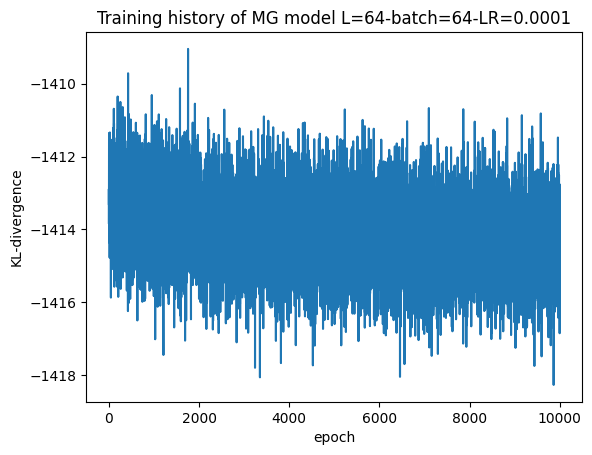

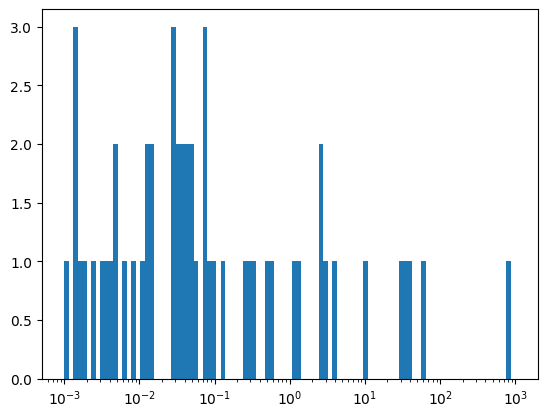

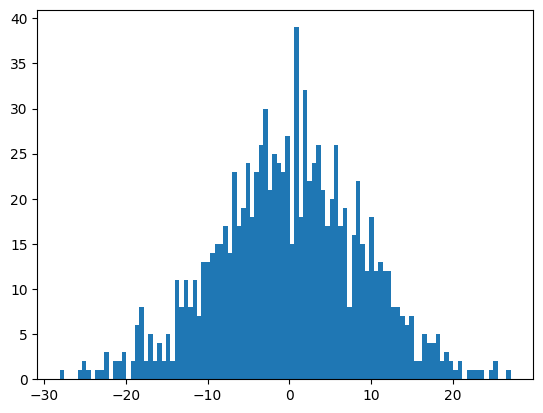

In [14]:
batch_size=64
super_batch_size = 1
learning_rate = 1.0e-4
optimizer = tr.optim.Adam([p for p in mg.parameters() if p.requires_grad==True], lr=learning_rate)

loss_history = []
pbar = tqdm(range(10000))
#tic=time.perf_counter()
for t in pbar:   
    #with torch.no_grad():
    #z = prior.sample((batch_size,1)).squeeze().reshape(batch_size,L,L)
    
    z = mg.prior_sample(batch_size)
    x = mg(z) # generate a sample
    tloss = (mg.log_prob(x)+o.action(x)).mean() # KL divergence (or not?)
    for b in range(1,super_batch_size):
        z = mg.prior_sample(batch_size)
        x = mg(z) # generate a sample
        tloss += (mg.log_prob(x)+o.action(x)).mean() # KL divergence (or not?)
    loss =tloss/super_batch_size
        
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    loss_history.append(loss.to("cpu").detach().numpy())
    pbar.set_postfix({'loss': loss.detach().to("cpu").numpy()})
    #print(loss_history[-1])
    #if t % 10 == 0:
    #    toc=time.perf_counter()
    #    #print(z.shape)
    #    print('iter %s:' % t, 'loss = %.3f' % loss,'time = %.3f' % (toc-tic),'seconds')
    #    tic=time.perf_counter()
        
x=mg.sample(1024)
diff = (o.action(x)+mg.log_prob(x)).detach()
m_diff = diff.mean()
diff -= m_diff
print("max  action diff: ", tr.max(diff.abs()).numpy())
print("min  action diff: ", tr.min(diff.abs()).numpy())
print("mean action diff: ", m_diff.detach().numpy())
print("std  action diff: ", diff.std().numpy())
#compute the reweighting factor 
foo = tr.exp(-diff)
#print(foo)
w = foo/tr.mean(foo)

print("mean re-weighting factor: " , w.mean().numpy())
print("std  re-weighting factor: " , w.std().numpy())
    
plt.plot(np.arange(len(loss_history)),loss_history)
plt.xlabel("epoch")
plt.ylabel("KL-divergence")
title = "L="+str(L)+"-batch="+str(batch_size)+"-LR="+str(learning_rate)
plt.title("Training history of MG model "+title)
#plt.show()
title = "L"+str(L)+"-batch"+str(batch_size)+"-LR"+str(learning_rate)
#plt.savefig("mg_train_"+title+".pdf")
plt.show()
#plt.close()
logbins = np.logspace(np.log10(1e-3),np.log10(1e3),int(w.shape[0]/10))
_=plt.hist(w,bins=logbins)
plt.xscale('log')
#plt.savefig("mg_rw_"+title+".pdf")
plt.show()
#plt.close()
_=plt.hist(diff.detach(),bins=int(w.shape[0]/10))
#plt.savefig("mg_ds_"+title+".pdf")

In [15]:
tr.save(mg.state_dict(), file)

In [16]:
class SuperModel(nn.Module):
    def __init__(self,models,target):
        super(SuperModel, self).__init__()
        self.size = models[0].size
        self.models=nn.ModuleList(models)
        self.No = len(models)
        self.prior = models[0].prior # keep the first model's prior as the prior
        self.target=target # the is the target negative log(probability) otherwise known as the action
        
    #noise to fields
    def forward(self,z):
        x=z
        for k in range(len(self.models)):
            x=self.models[k].forward(x)
        return x
    
    #fields to noise
    def backward(self,x):
        log_det_J=x.new_zeros(x.shape[0])
        z=x
        for k in range(len(self.models)-1,-1,-1):
            z,J=self.models[k].backward(z)
            log_det_J+=J
        
        return z,log_det_J
            
    def log_prob(self,x):
        z, logp = self.backward(x)
        #print("In log prob z.shape: ", z.shape)
        return self.prior.log_prob(z.flatten(start_dim=1)) + logp     
        
    def sample(self, batchSize): 
        #z = self.prior.sample((batchSize, 1)).reshape(batchSize,self.size[0],self.size[1])
        z = self.prior_sample(batchSize)
        x = self.forward(z)
        return x

    # generate a sample from the prior
    def prior_sample(self,batch_size):
        return self.prior.sample((batch_size,1)).reshape(batch_size,self.size[0],self.size[1])

    def loss(self,x):
        return (self.log_prob(x)+self.target(x)).mean()
        

In [17]:
def trainSM( SuperM, levels=[], epochs=100,batch_size=16,super_batch_size=1,learning_rate=1.0e-4):
    params = []
    if levels==[] :
        params = [p for p in SuperM.parameters() if p.requires_grad==True]
    else:
        for l in levels:
            params.extend([p for p in SuperM.models[l].parameters() if p.requires_grad==True])
    print("Number of parameters to train is: ",len(params))
    optimizer = tr.optim.Adam(params, lr=learning_rate)
    loss_history = []
    #tic=time.perf_counter()
    pbar = tqdm(range(epochs))
    for t in pbar:   
        z = SuperM.prior_sample(batch_size)
        x = SuperM(z) # generate a sample
        tloss = SuperM.loss(x) #(SuperM.log_prob(x)+o.action(x)).mean() # KL divergence (or not?)
        for b in range(1,super_batch_size):
            z = SuperM.prior_sample(batch_size)
            x = SuperM(z) # generate a sample
            tloss += SuperM.loss(x)#(sm.log_prob(x)+o.action(x)).mean() # KL divergence (or not?)
        loss =tloss/super_batch_size    
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        loss_history.append(loss.detach().numpy())
        pbar.set_postfix({'loss': loss.detach().numpy()})
        #print(loss_history[-1])
        #if t % 10 == 0:
        #    toc=time.perf_counter()
        #    print('iter %s:' % t, 'loss = %.3f' % loss,'time = %.3f' % (toc-tic),'seconds')
        #    tic=time.perf_counter()
    return loss_history
           

In [18]:
def plot_loss(lh):
    plt.plot(np.arange(len(lh)),lh)
    plt.xlabel("epoch")
    plt.ylabel("KL-divergence")
    plt.title("Training history of MG super model ")
    plt.show()
    #title = "L="+str(L)+"-batch="+str(batch_size)+"-LR="+str(learning_rate)

In [19]:
def validate(batch_size,mm):
    x=mm.sample(1024)
    diff = (o.action(x)+mm.log_prob(x)).detach()
    m_diff = diff.mean()
    diff -= m_diff
    print("max  action diff: ", tr.max(diff.abs()).numpy())
    print("min  action diff: ", tr.min(diff.abs()).numpy())
    print("mean action diff: ", m_diff.detach().numpy())
    print("std  action diff: ", diff.std().numpy())
    #compute the reweighting factor
    foo = tr.exp(-diff)
    #print(foo)
    w = foo/tr.mean(foo)

    print("mean re-weighting factor: " , w.mean().numpy())
    print("std  re-weighting factor: " , w.std().numpy())
    
    #plt.show()
    #title = "L"+str(L)+"-batch"+str(batch_size)+"-LR"+str(learning_rate)
    #plt.savefig("sm_mg_train_"+title+".pdf")
    #plt.show()
    #plt.close()
    logbins = np.logspace(np.log10(1e-3),np.log10(1e3),int(w.shape[0]/10))
    _=plt.hist(w,bins=logbins)
    plt.xscale('log')
    plt.title('Reweighting factor')
    #plt.savefig("sm_mg_rw_"+title+".pdf")
    plt.show()
    #plt.close()
    _=plt.hist(diff.detach(),bins=int(w.shape[0]/10))
    plt.title('ΔS distribution')
    #plt.savefig("sm_mg_ds_"+title+".pdf")

In [20]:
#sm = SuperModel([m.MGflow([L,L],bij,m.RGlayer("average"),prior),m.MGflow([L,L],bij,m.RGlayer("average"),prior)])

sm = SuperModel([m.MGflow([L,L],bij,m.RGlayer("average"),prior),mg],target =o.action )


Initializing MGflow module wiht size:  64
Using depth:  6
Using rg type:  average
(depth, size):  0 [64, 64]
(depth, size):  1 [32, 32]
(depth, size):  2 [16, 16]
(depth, size):  3 [8, 8]
(depth, size):  4 [4, 4]
(depth, size):  5 [2, 2]


In [21]:
c=0
for tt in sm.parameters():
    #print(tt.shape)
    if tt.requires_grad==True :
        c+=tt.numel()
        
print("parameter count: ",c)

parameter count:  40320


In [22]:
x=mg.sample(128)
z,J=sm.backward(x)
xx=sm.forward(z)
dd = tr.sum(tr.abs(xx -x)).detach()
print(dd/(x.shape[0]*x.shape[1]*x.shape[2]))

tensor(2.5965e-07)


In [23]:
z = sm.prior_sample(128)
x=sm.forward(z)
zz,J=sm.backward(x)
dd = tr.sum(tr.abs(zz -z)).detach()
print(dd/(x.shape[0]*x.shape[1]*x.shape[2]))

tensor(2.7617e-07)


Number of parameters to train is:  288


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:08<00:00,  7.77it/s, loss=-1392.7183]


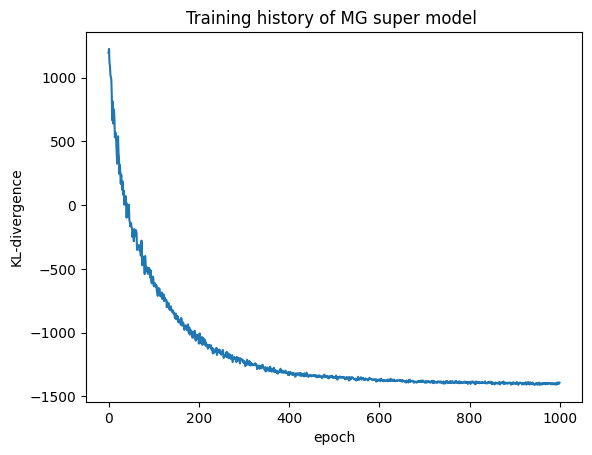

max  action diff:  33.698853
min  action diff:  0.015014648
mean action diff:  -1401.0043
std  action diff:  9.730386
mean re-weighting factor:  1.0
std  re-weighting factor:  15.770074


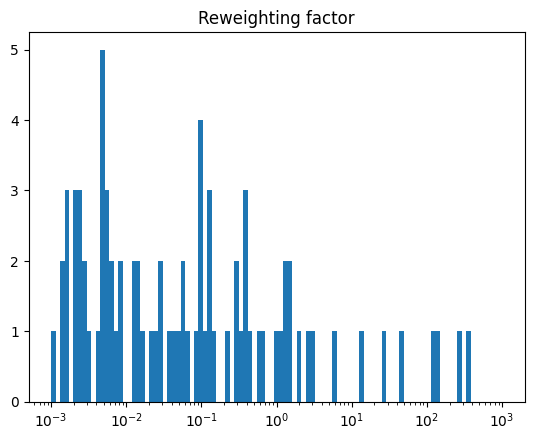

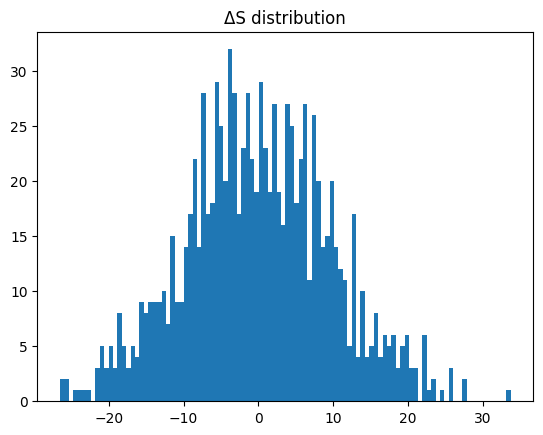

In [24]:
loss_hist=trainSM( sm,levels=[0], epochs=1000,batch_size=4,super_batch_size=1)
plot_loss(loss_hist)
validate(1024,sm)

Number of parameters to train is:  288


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:04<00:00,  8.06it/s, loss=-1415.2192]


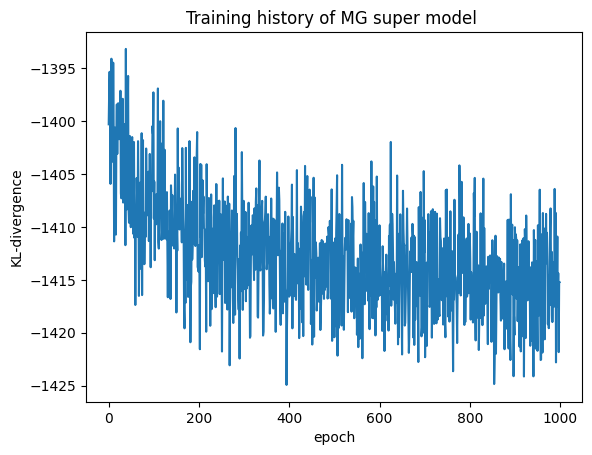

max  action diff:  28.295532
min  action diff:  0.010253906
mean action diff:  -1415.2412
std  action diff:  8.235361
mean re-weighting factor:  1.0000001
std  re-weighting factor:  18.651522


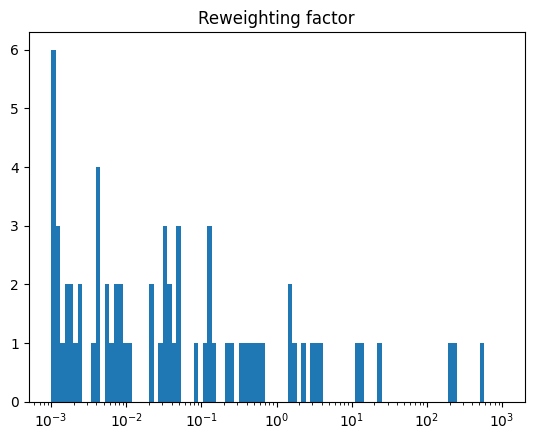

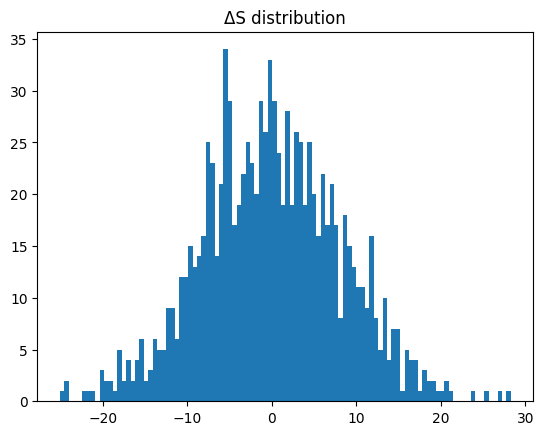

In [25]:
loss_hist=trainSM( sm,levels=[0], epochs=1000,batch_size=4,super_batch_size=1)
plot_loss(loss_hist)
validate(1024,sm)

Number of parameters to train is:  576


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:13<00:00,  7.51it/s, loss=-1421.169]


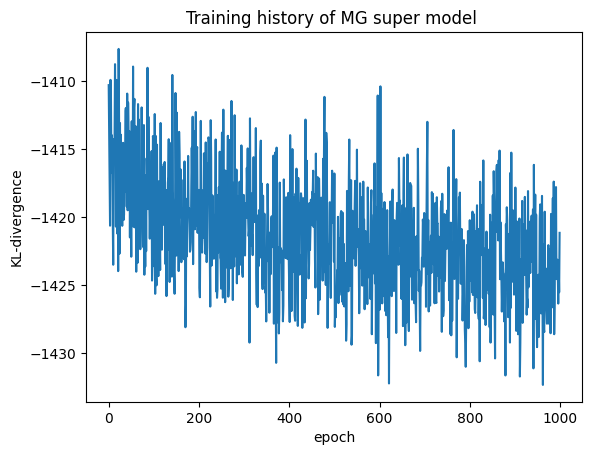

max  action diff:  23.4646
min  action diff:  0.01940918
mean action diff:  -1423.2866
std  action diff:  7.2289796
mean re-weighting factor:  1.0
std  re-weighting factor:  29.760216


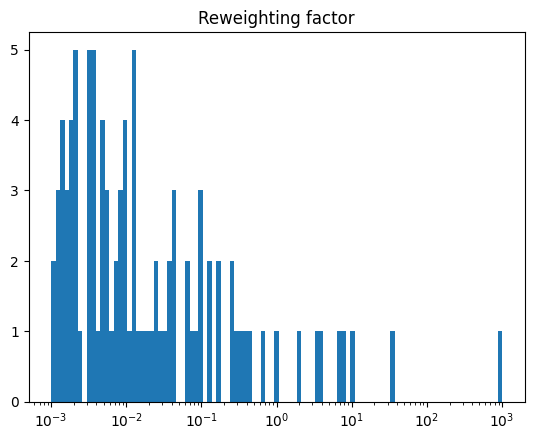

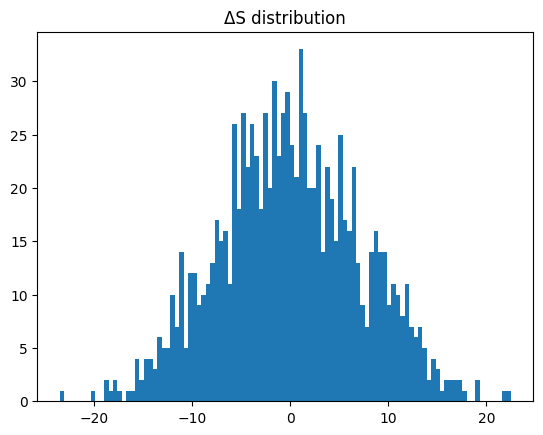

In [26]:
loss_hist=trainSM( sm,levels=[], epochs=1000,batch_size=4,super_batch_size=1)
plot_loss(loss_hist)
validate(1024,sm)

Number of parameters to train is:  576


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:11<00:00,  7.58it/s, loss=-1423.3418]


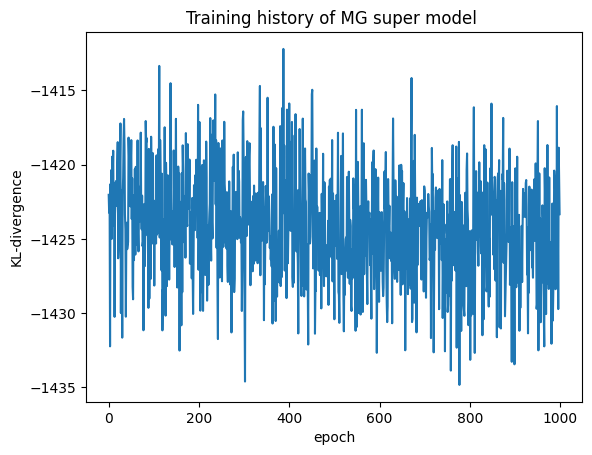

max  action diff:  22.40332
min  action diff:  0.0017089844
mean action diff:  -1425.2891
std  action diff:  6.893143
mean re-weighting factor:  1.0
std  re-weighting factor:  19.42922


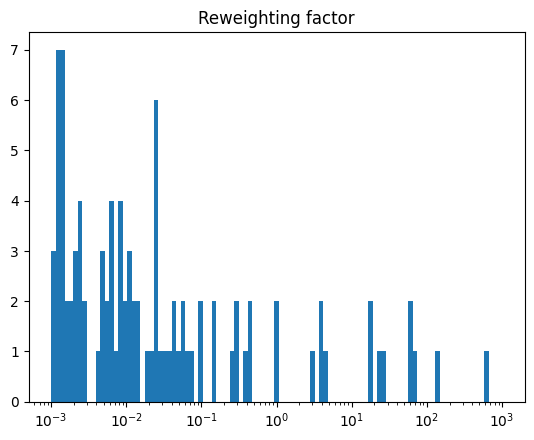

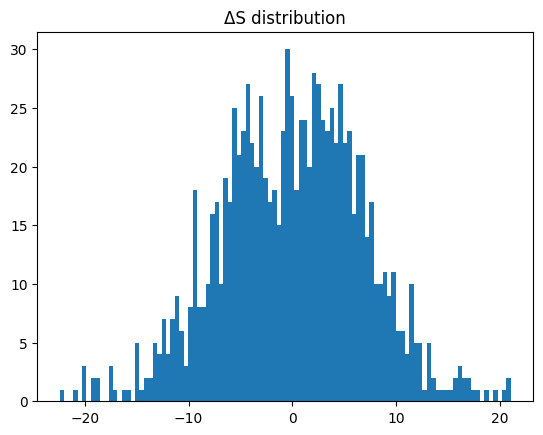

In [27]:
loss_hist=trainSM( sm,levels=[], epochs=1000,batch_size=4,super_batch_size=1)
plot_loss(loss_hist)
validate(1024,sm)

Number of parameters to train is:  576


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [32:13<00:00,  5.17it/s, loss=-1438.5198]


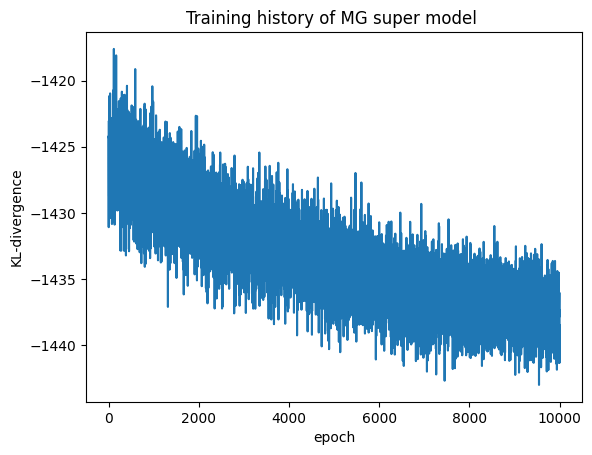

max  action diff:  14.886108
min  action diff:  0.008300781
mean action diff:  -1437.6477
std  action diff:  4.756805
mean re-weighting factor:  1.0
std  re-weighting factor:  8.246004


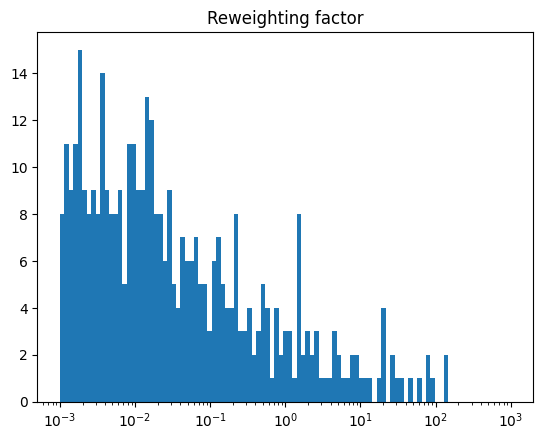

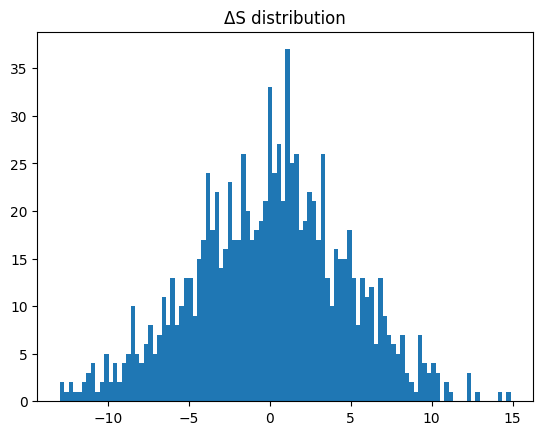

In [28]:
loss_hist=trainSM( sm,levels=[], epochs=10000,batch_size=8,super_batch_size=1)
plot_loss(loss_hist)
validate(1024,sm)

Number of parameters to train is:  576


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [48:54<00:00,  3.41it/s, loss=-1440.7856]


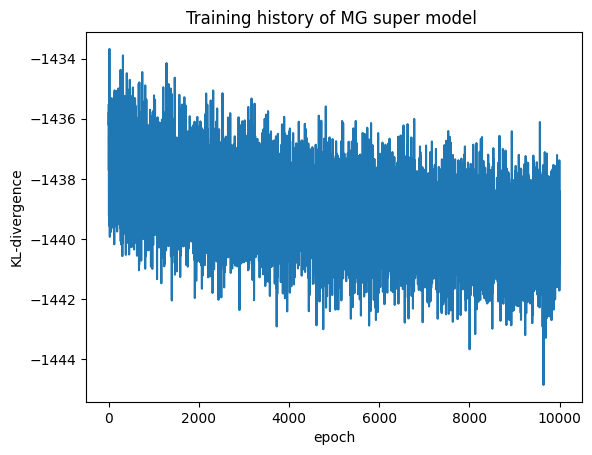

max  action diff:  12.673096
min  action diff:  0.0013427734
mean action diff:  -1440.0446
std  action diff:  4.3585978
mean re-weighting factor:  0.99999994
std  re-weighting factor:  8.240759


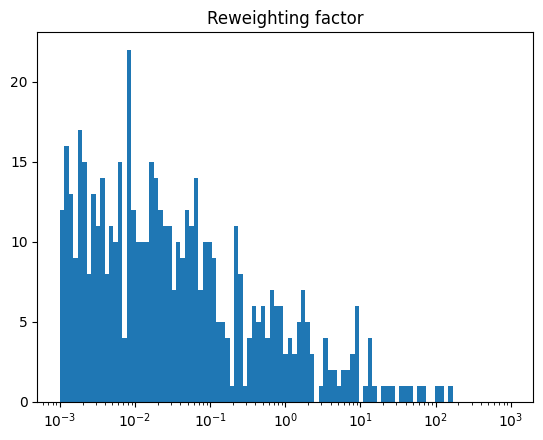

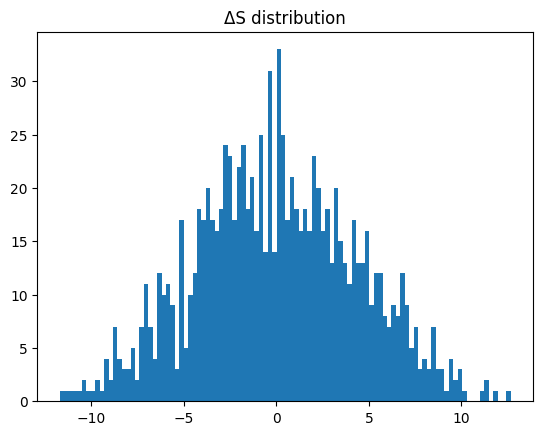

In [29]:
loss_hist=trainSM( sm,levels=[], epochs=10000,batch_size=16,super_batch_size=1)
plot_loss(loss_hist)
validate(1024,sm)

In [30]:
foo = [m.MGflow([L,L],bij,m.RGlayer("average"),prior)]
foo.extend(sm.models)
sm2 = SuperModel(foo,target =o.action )


Initializing MGflow module wiht size:  64
Using depth:  6
Using rg type:  average
(depth, size):  0 [64, 64]
(depth, size):  1 [32, 32]
(depth, size):  2 [16, 16]
(depth, size):  3 [8, 8]
(depth, size):  4 [4, 4]
(depth, size):  5 [2, 2]


Number of parameters to train is:  288


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:04<00:00,  5.42it/s, loss=-1432.5454]


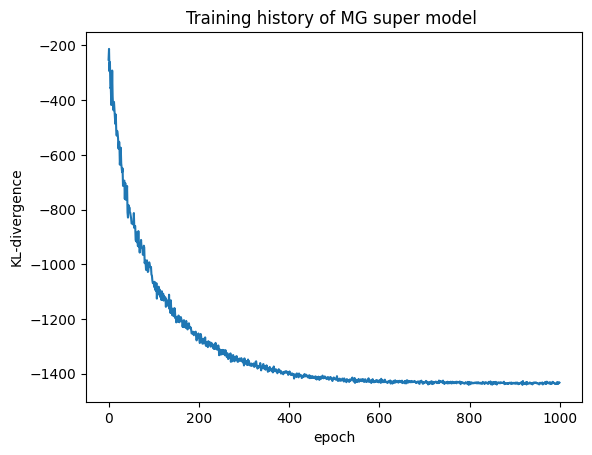

max  action diff:  18.332886
min  action diff:  0.0052490234
mean action diff:  -1435.2703
std  action diff:  5.2757955
mean re-weighting factor:  1.0000001
std  re-weighting factor:  22.945276


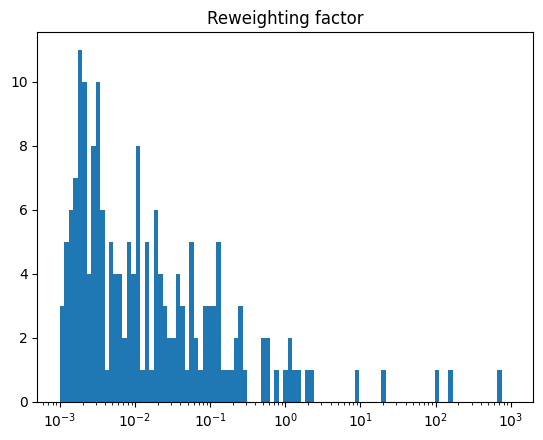

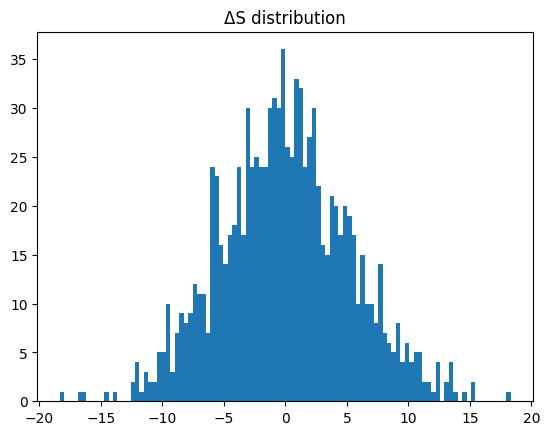

In [31]:
loss_hist=trainSM( sm2,levels=[0], epochs=1000,batch_size=4,super_batch_size=1)
plot_loss(loss_hist)
validate(1024,sm2)

Number of parameters to train is:  288


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [30:22<00:00,  5.49it/s, loss=-1437.0513]


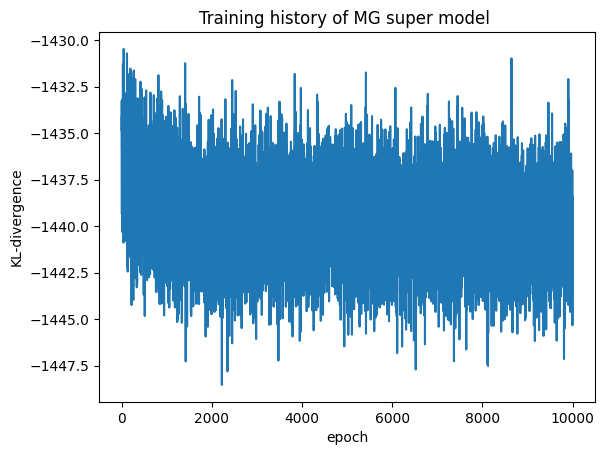

max  action diff:  13.994141
min  action diff:  0.01953125
mean action diff:  -1439.7798
std  action diff:  4.318226
mean re-weighting factor:  1.0
std  re-weighting factor:  16.775436


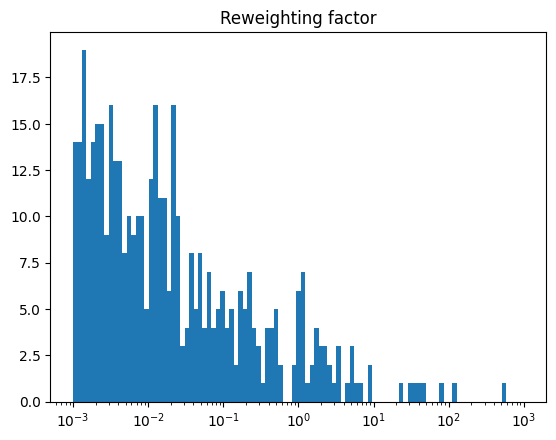

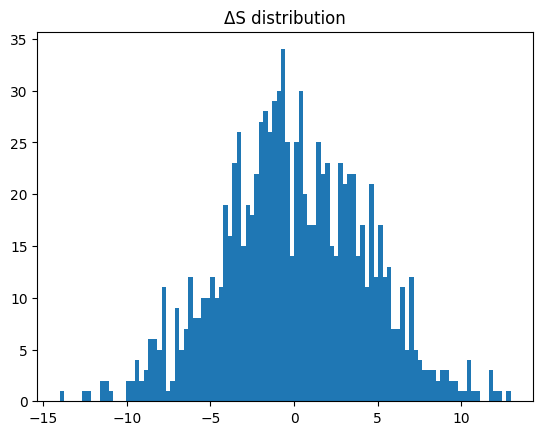

In [32]:
loss_hist=trainSM( sm2,levels=[0], epochs=10000,batch_size=4,super_batch_size=1)
plot_loss(loss_hist)
validate(1024,sm2)

Number of parameters to train is:  864


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [2:33:43<00:00,  1.08it/s, loss=-1438.7028]


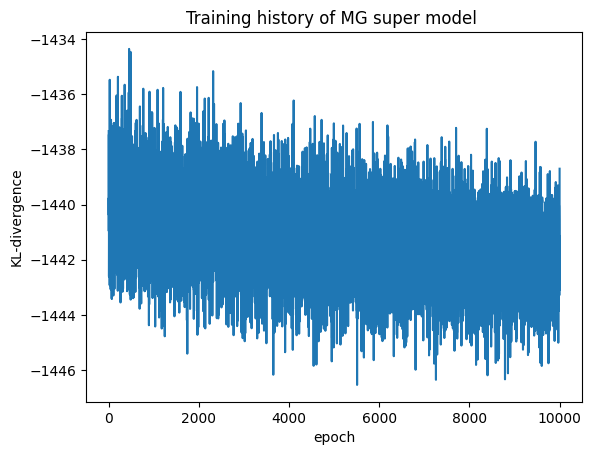

max  action diff:  12.9227295
min  action diff:  0.001953125
mean action diff:  -1442.1863
std  action diff:  3.8551204
mean re-weighting factor:  1.0
std  re-weighting factor:  18.851383


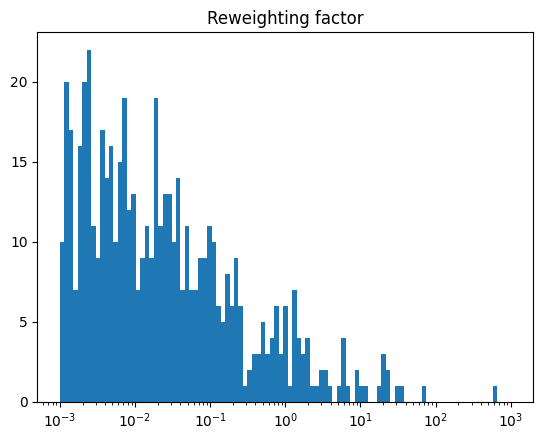

Number of parameters to train is:  864


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [1:12:31<00:00,  2.30it/s, loss=-1443.2216]


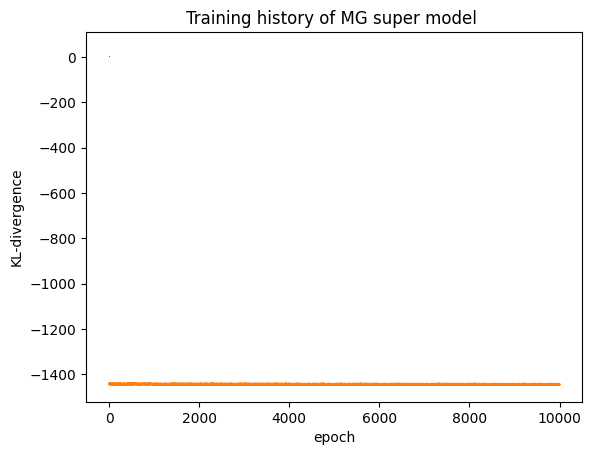

max  action diff:  12.807617
min  action diff:  0.0057373047
mean action diff:  -1443.2811
std  action diff:  3.4833052
mean re-weighting factor:  1.0
std  re-weighting factor:  7.3617225


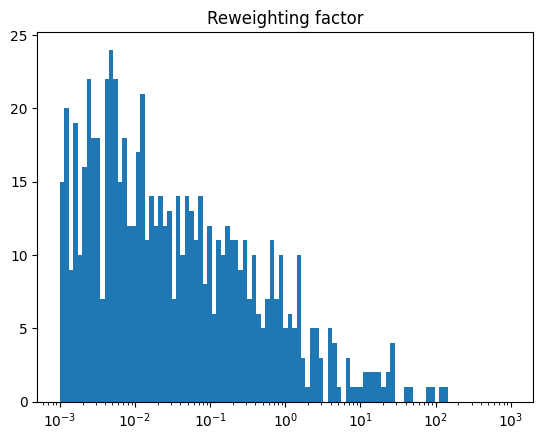

Number of parameters to train is:  864


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [3:47:32<00:00,  1.37s/it, loss=-1443.2087]


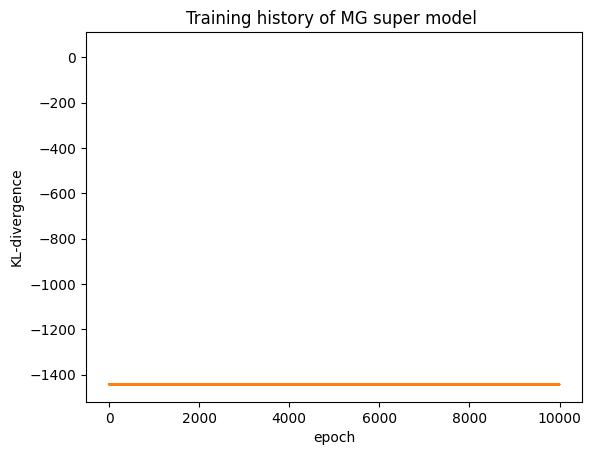

max  action diff:  12.837036
min  action diff:  0.0029296875
mean action diff:  -1443.9586
std  action diff:  3.2877018
mean re-weighting factor:  0.99999994
std  re-weighting factor:  15.190729


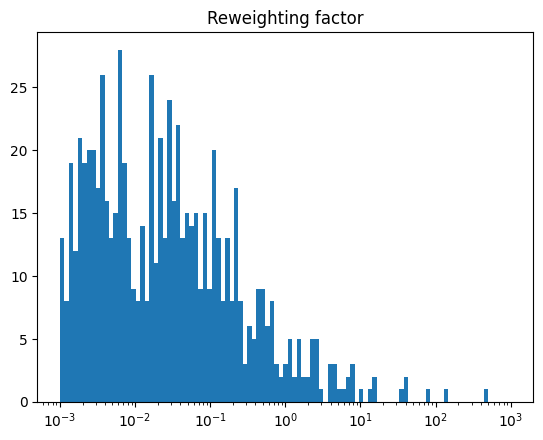

Number of parameters to train is:  864


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [12:14:22<00:00,  4.41s/it, loss=-1443.9783]


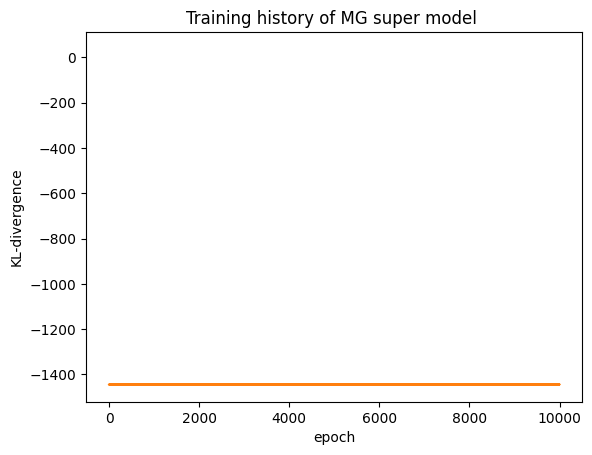

max  action diff:  15.066406
min  action diff:  0.0017089844
mean action diff:  -1444.3147
std  action diff:  3.2294838
mean re-weighting factor:  1.0
std  re-weighting factor:  5.6311674


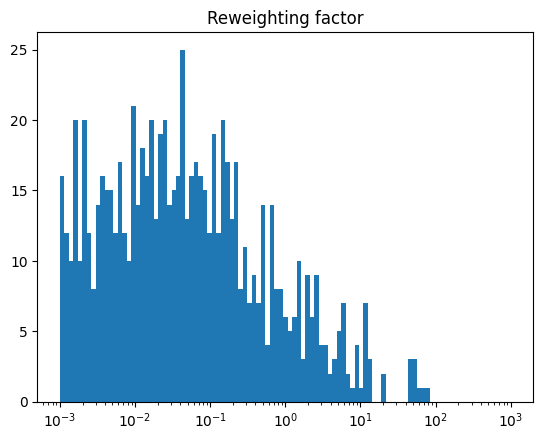

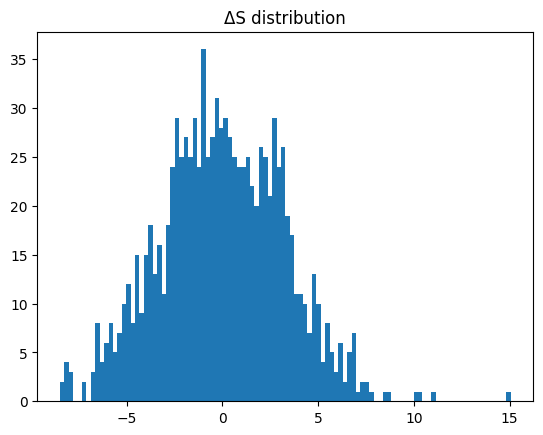

In [33]:
loss_hist=trainSM( sm2,levels=[], epochs=10000,batch_size=8,super_batch_size=1)
plot_loss(loss_hist)
validate(1024,sm2)
loss_hist=trainSM( sm2,levels=[], epochs=10000,batch_size=16,super_batch_size=1)
plot_loss(loss_hist)
validate(1024,sm2)
loss_hist=trainSM( sm2,levels=[], epochs=10000,batch_size=32,super_batch_size=1)
plot_loss(loss_hist)
validate(1024,sm2)
loss_hist=trainSM( sm2,levels=[], epochs=10000,batch_size=64,super_batch_size=1)
plot_loss(loss_hist)
validate(1024,sm2)

In [34]:
foo = [m.MGflow([L,L],bij,m.RGlayer("average"),prior)]
foo.extend(sm2.models)
sm3 = SuperModel(foo,target =o.action )

Initializing MGflow module wiht size:  64
Using depth:  6
Using rg type:  average
(depth, size):  0 [64, 64]
(depth, size):  1 [32, 32]
(depth, size):  2 [16, 16]
(depth, size):  3 [8, 8]
(depth, size):  4 [4, 4]
(depth, size):  5 [2, 2]


Number of parameters to train is:  288


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [17:47<00:00,  1.07s/it, loss=-1438.3456]


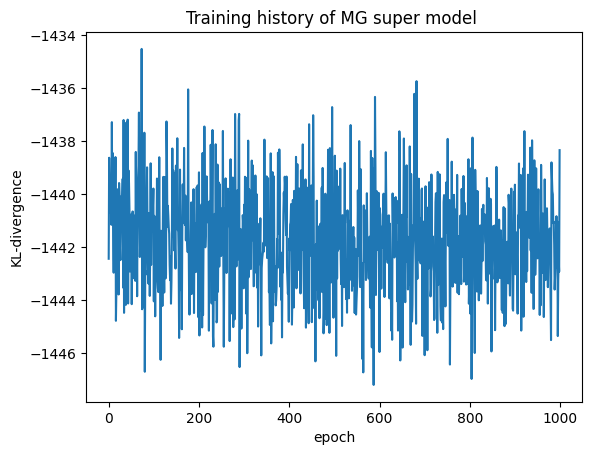

max  action diff:  13.406006
min  action diff:  0.0029296875
mean action diff:  -1441.8354
std  action diff:  3.873379
mean re-weighting factor:  1.0
std  re-weighting factor:  12.848364


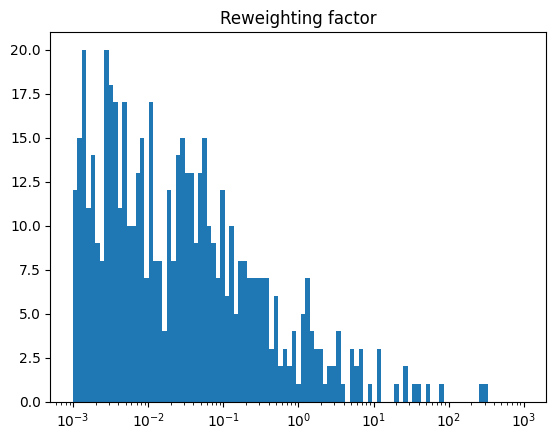

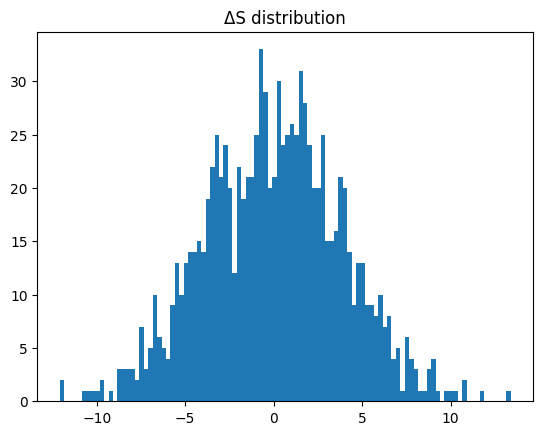

In [ ]:
loss_hist=trainSM( sm3,levels=[0], epochs=1000,batch_size=4,super_batch_size=1)
plot_loss(loss_hist)
validate(1024,sm3)

Number of parameters to train is:  864


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [3:37:17<00:00,  1.30s/it, loss=-1442.054]


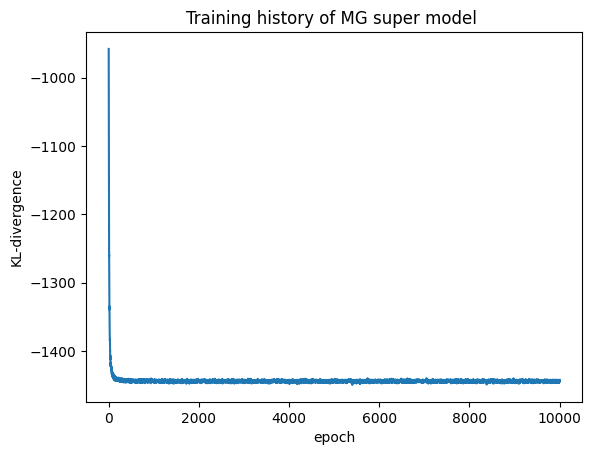

max  action diff:  9.092651
min  action diff:  0.0020751953
mean action diff:  -1444.0496
std  action diff:  3.213018
mean re-weighting factor:  1.0000001
std  re-weighting factor:  6.085866


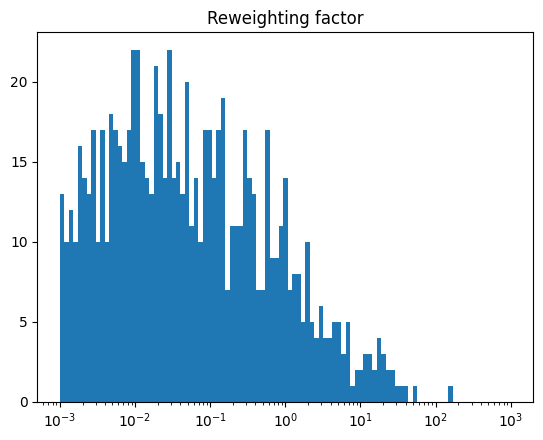

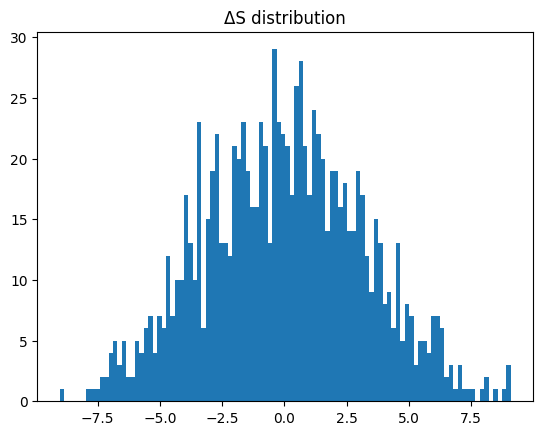

In [ ]:
loss_hist=trainSM( sm2,levels=[], epochs=10000,batch_size=8,super_batch_size=1)
plot_loss(loss_hist)
validate(1024,sm2)

In [ ]:
c=0
for tt in sm3.parameters():
    #print(tt.shape)
    if tt.requires_grad==True :
        c+=tt.numel()
        
print("parameter count: ",c)

parameter count:  80640


Batch size:  4
Number of parameters to train is:  1152


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:22:11<00:00,  1.01it/s, loss=-1443.7878]


Batch size:  8
Number of parameters to train is:  1152


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [2:12:28<00:00,  1.59s/it, loss=-1444.3885]


Batch size:  16
Number of parameters to train is:  1152


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [3:13:01<00:00,  2.32s/it, loss=-1445.209]


Batch size:  32
Number of parameters to train is:  1152


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [5:21:19<00:00,  3.86s/it, loss=-1445.1091]


Batch size:  64
Number of parameters to train is:  1152


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [7:13:13<00:00,  5.20s/it, loss=-1444.9482]


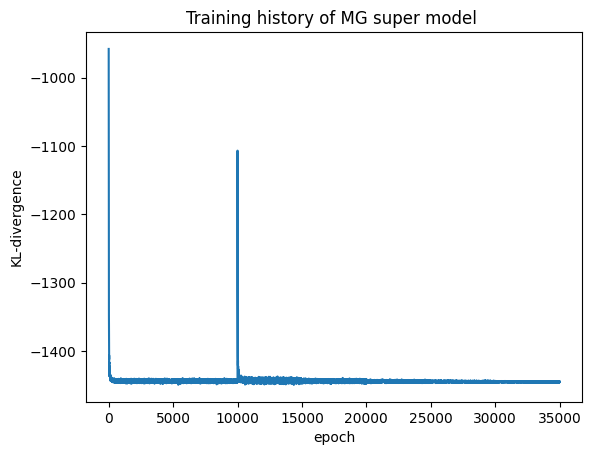

max  action diff:  12.660889
min  action diff:  0.0007324219
mean action diff:  -1445.1846
std  action diff:  2.8336742
mean re-weighting factor:  1.0000002
std  re-weighting factor:  10.599252


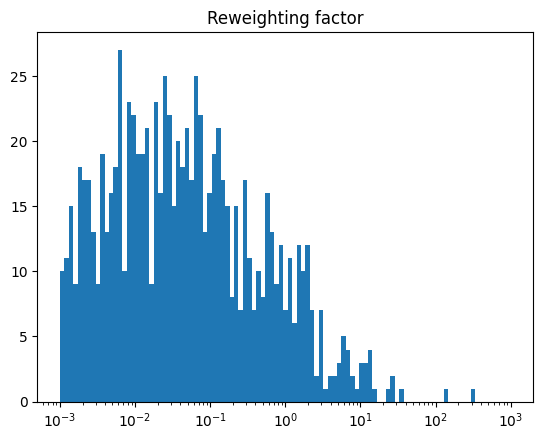

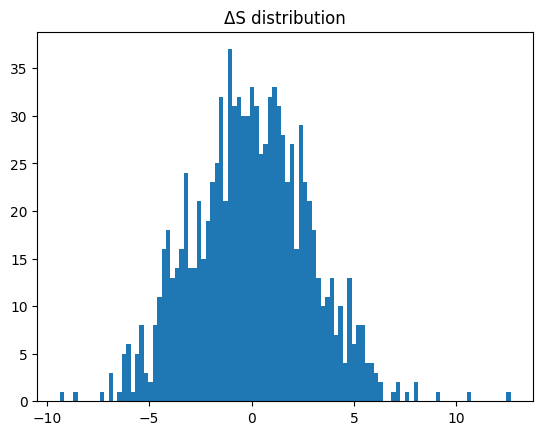

In [ ]:
loss_hist = []
for b in [4,8,16,32,64]:
    print("Batch size: ",b)
    ll=trainSM( sm3,levels=[], epochs=5000,batch_size=b,super_batch_size=1)
    loss_hist.extend(ll)
plot_loss(loss_hist)
validate(1024,sm3)

In [40]:
len(sm3.models)

4

In [42]:
tr.save(sm3.state_dict() ,'sm_phi4_64_m-0.2_l1.0_st_4.dict')

In [43]:
foo = [m.MGflow([L,L],bij,m.RGlayer("average"),prior)]
foo.extend(sm3.models)
sm4 = SuperModel(foo,target =o.action )

Initializing MGflow module wiht size:  64
Using depth:  6
Using rg type:  average
(depth, size):  0 [64, 64]
(depth, size):  1 [32, 32]
(depth, size):  2 [16, 16]
(depth, size):  3 [8, 8]
(depth, size):  4 [4, 4]
(depth, size):  5 [2, 2]


Number of parameters to train is:  288


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:07:05<00:00,  1.24it/s, loss=-1446.6313]


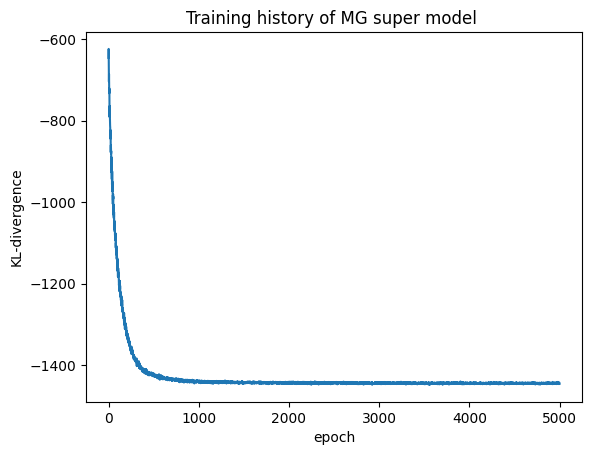

max  action diff:  11.99353
min  action diff:  0.0048828125
mean action diff:  -1445.0106
std  action diff:  2.8760605
mean re-weighting factor:  1.0
std  re-weighting factor:  12.011658


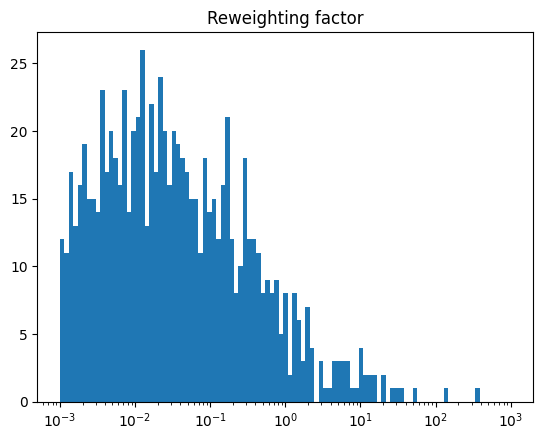

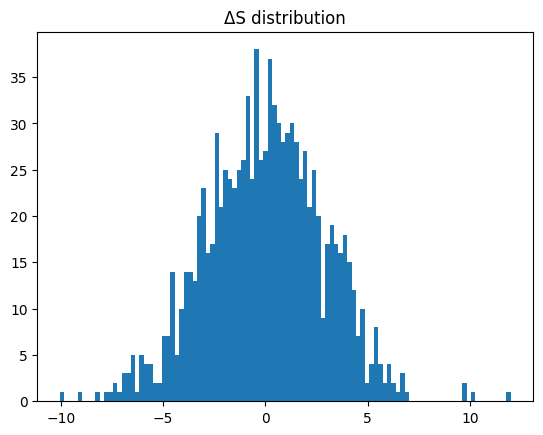

In [44]:
ll=trainSM( sm4,levels=[0], epochs=5000,batch_size=8,super_batch_size=1)
plot_loss(ll)
validate(1024,sm4)

Number of parameters to train is:  288


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:01:43<00:00,  1.35it/s, loss=-1445.9602]


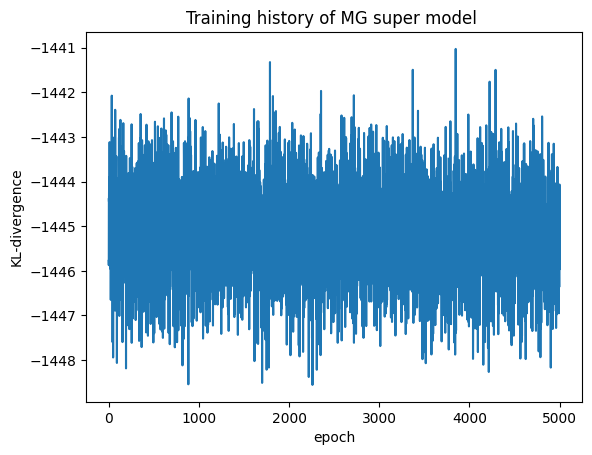

max  action diff:  10.444214
min  action diff:  0.00024414062
mean action diff:  -1445.2683
std  action diff:  2.9235756
mean re-weighting factor:  1.0000001
std  re-weighting factor:  12.1825075


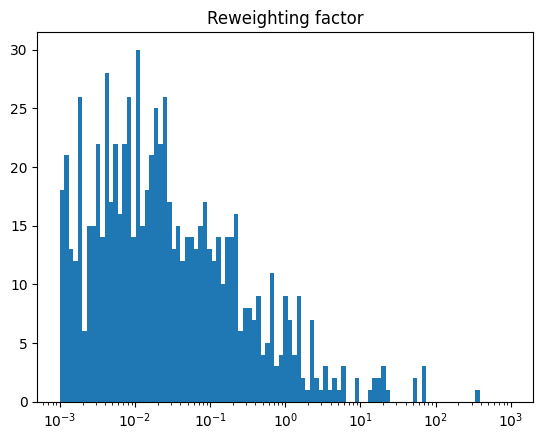

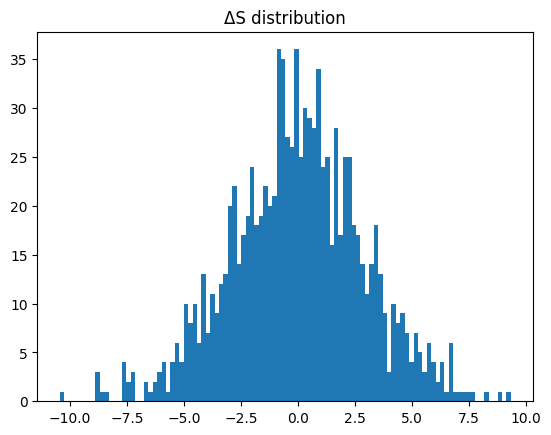

In [45]:
ll=trainSM( sm4,levels=[0], epochs=5000,batch_size=8,super_batch_size=1)
plot_loss(ll)
validate(1024,sm4)

Batch size:  16
Number of parameters to train is:  1440


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [23:01<00:00,  1.45it/s, loss=-1445.4045]


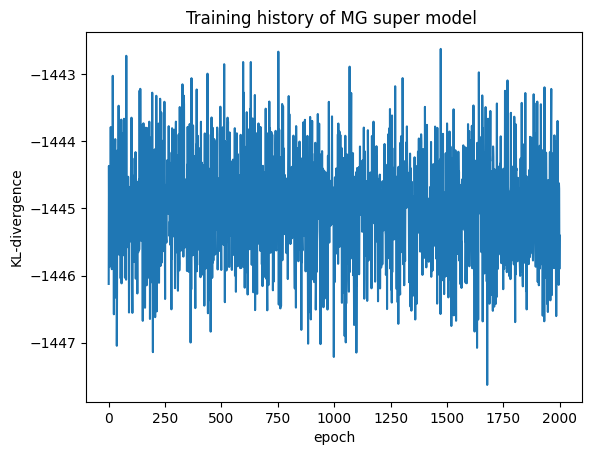

max  action diff:  10.233398
min  action diff:  0.00048828125
mean action diff:  -1445.1713
std  action diff:  2.9351265
mean re-weighting factor:  0.9999999
std  re-weighting factor:  11.401518


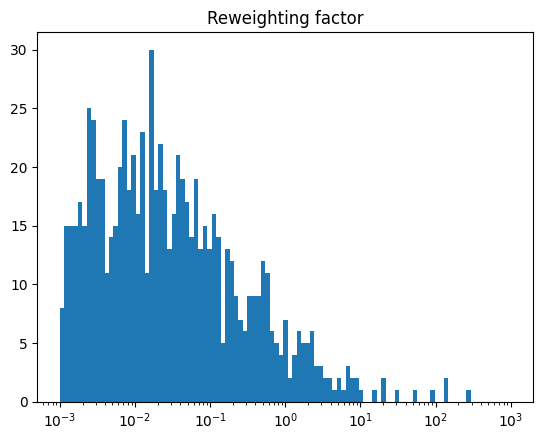

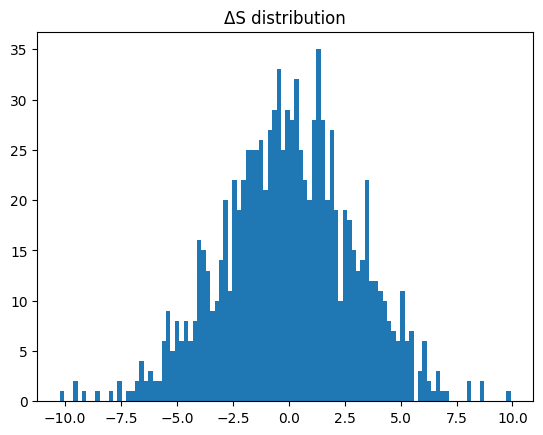

In [47]:
loss_hist = []
for b in [16]:
    print("Batch size: ",b)
    ll=trainSM( sm4,levels=[], epochs=2000,batch_size=b,super_batch_size=1)
    loss_hist.extend(ll)
plot_loss(loss_hist)
validate(1024,sm4)

In [46]:
tr.save(sm4.state_dict() ,'sm_phi4_64_m-0.2_l1.0_st_5.dict')